Dataset already exists.

Train dataset:
Number of samples: 21841
Class '0': 941 images
Class '1': 942 images
Class '2': 932 images
Class '3': 580 images
Class '4': 949 images
Class '5': 943 images
Class '6': 949 images
Class '7': 928 images
Class '8': 921 images
Class '9': 940 images
Class '10': 67 images
Class '11': 67 images
Class '12': 66 images
Class '13': 67 images
Class '14': 67 images
Class '15': 66 images
Class '16': 67 images
Class '17': 67 images
Class '18': 66 images
Class '19': 67 images
Class '20': 67 images
Class '21': 66 images
Class '22': 67 images
Class '23': 67 images
Class '24': 66 images
Class '25': 67 images
Class '26': 67 images
Class '27': 66 images
Class '28': 67 images
Class '29': 67 images
Class '30': 66 images
Class '31': 67 images
Class '32': 67 images
Class '33': 66 images
Class '34': 67 images
Class '35': 67 images
Class '36': 66 images
Class '37': 67 images
Class '38': 67 images
Class '39': 66 images
Class '40': 67 images
Class '41': 67 images
Class '42':

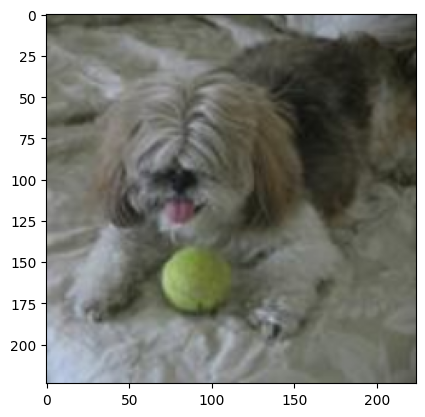

Example image size: torch.Size([3, 224, 224])

Test dataset:
Number of samples: 8282
Class '0': 409 images
Class '1': 408 images
Class '2': 418 images
Class '3': 224 images
Class '4': 401 images
Class '5': 407 images
Class '6': 401 images
Class '7': 422 images
Class '8': 429 images
Class '9': 410 images
Class '10': 33 images
Class '11': 33 images
Class '12': 34 images
Class '13': 33 images
Class '14': 33 images
Class '15': 34 images
Class '16': 33 images
Class '17': 33 images
Class '18': 34 images
Class '19': 33 images
Class '20': 33 images
Class '21': 34 images
Class '22': 33 images
Class '23': 33 images
Class '24': 34 images
Class '25': 33 images
Class '26': 33 images
Class '27': 34 images
Class '28': 33 images
Class '29': 33 images
Class '30': 34 images
Class '31': 33 images
Class '32': 33 images
Class '33': 34 images
Class '34': 33 images
Class '35': 33 images
Class '36': 34 images
Class '37': 33 images
Class '38': 33 images
Class '39': 34 images
Class '40': 33 images
Class '41': 3

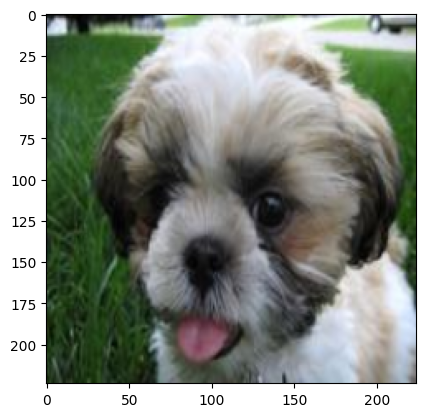

Example image size: torch.Size([3, 224, 224])


In [9]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import ConcatDataset, DataLoader
from torchvision.datasets import ImageFolder
import urllib.request
import tarfile

def download_imagewoof(url, download_path, extract_path):
    if not os.path.exists(os.path.dirname(download_path)):  # Check if the directory exists
        print(f"Creating directory {os.path.dirname(download_path)}...")
        os.makedirs(os.path.dirname(download_path))  # Create the directory if it doesn't exist

    if not os.path.exists(extract_path):  # Check if the dataset is already extracted
        print(f"Downloading dataset from {url}...")
        urllib.request.urlretrieve(url, download_path)  # Download the dataset
        print(f"Download complete. Extracting files...")

        # Extract the .tgz file
        with tarfile.open(download_path, 'r:gz') as tar:
            tar.extractall(path=extract_path)  # Extract files to the specified folder
        print("Extraction complete.")
    else:
        print("Dataset already exists.")

# URL for ImageWoof dataset
imagewoof_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz'
download_path = './data/imagewoof2-160.tgz'
extract_path = './data/imagewoof2-160'  # Path to extract the files

# Download and extract the ImageWoof dataset
download_imagewoof(imagewoof_url, download_path, extract_path)

# Set the directories for train and validation sets
train_dir = os.path.join(extract_path, 'imagewoof2-160/train')
valid_dir = os.path.join(extract_path, 'imagewoof2-160/val')

# Define directories for the datasets
fgvc_aircraft_root = './data'
imagewoof_root = './data/imagewoof2-160'
flowers102_root = './data/flowers-102'

# Define transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 (standard for pretrained models)
    transforms.ToTensor()  # Convert image to tensor
])

# Load datasets using PyTorch built-in datasets and split options
fgvc_trainval = torchvision.datasets.FGVCAircraft(root=fgvc_aircraft_root, split='trainval', download=True, transform=transform)
fgvc_test = torchvision.datasets.FGVCAircraft(root=fgvc_aircraft_root, split='test', download=True, transform=transform)

flowers_train = torchvision.datasets.Flowers102(root=flowers102_root, split='test', download=True, transform=transform)
flowers_test = torchvision.datasets.Flowers102(root=flowers102_root, split='train', download=True, transform=transform)

# Load ImageWoof dataset using ImageFolder (train and val)
train_dir = os.path.join(imagewoof_root, 'imagewoof2-160/train')
valid_dir = os.path.join(imagewoof_root, 'imagewoof2-160/val')

imagewoof_train = ImageFolder(root=train_dir, transform=transform)
imagewoof_val = ImageFolder(root=valid_dir, transform=transform)

# Function to update targets
def update_targets(dataset, start_label):
    dataset.targets = [label for _, label in dataset]
    unique_labels = set(dataset.targets)

    return dataset, start_label + len(unique_labels)

# Remap labels for each dataset to avoid conflicts
start_label = 0

imagewoof_train, start_label_fgcv = update_targets(imagewoof_train, start_label)
imagewoof_val, _ = update_targets(imagewoof_val, start_label)


class ModifiedFGVCAircraft(torchvision.datasets.FGVCAircraft):
    def __init__(self, root, split='trainval', download=False, transform=None, startlabel=0):
        super(ModifiedFGVCAircraft, self).__init__(root=root, split=split, download=download, transform=transform)
        self.startlabel = startlabel
    def __getitem__(self, index):
        image, label = super(ModifiedFGVCAircraft, self).__getitem__(index)
        # Add the scalar to the label when returning
        label += self.startlabel
        return image, label
fgvc_trainval = ModifiedFGVCAircraft(root=fgvc_aircraft_root, split='trainval', download=True, transform=transform, startlabel=start_label_fgcv)
fgvc_test = ModifiedFGVCAircraft(root=fgvc_aircraft_root, split='test', download=True, transform=transform, startlabel=start_label_fgcv)

fgvc_trainval, start_label_flowers = update_targets(fgvc_trainval, start_label_fgcv)
fgvc_test, _ = update_targets(fgvc_test, start_label_fgcv)


class ModifiedFlowers102(torchvision.datasets.Flowers102):
    def __init__(self, root, split='train', download=False, transform=None, startlabel=0):
        super(ModifiedFlowers102, self).__init__(root=root, split=split, download=download, transform=transform)
        self.startlabel = startlabel
    def __getitem__(self, index):
        image, label = super(ModifiedFlowers102, self).__getitem__(index)
        # Add the scalar to the label when returning
        label += self.startlabel
        return image, label
flowers_train = ModifiedFlowers102(root=flowers102_root, split='test', download=True, transform=transform, startlabel=start_label_flowers)
flowers_test = ModifiedFlowers102(root=flowers102_root, split='train', download=True, transform=transform, startlabel=start_label_flowers)

flowers_train, _ = update_targets(flowers_train, start_label_flowers)
flowers_test, _ = update_targets(flowers_test, start_label_flowers)


# Create train and test datasets as per the requirement
train_dataset = ConcatDataset([imagewoof_train, fgvc_trainval, flowers_train])
test_dataset = ConcatDataset([imagewoof_val, fgvc_test, flowers_test])

# Function to display dataset details
def display_dataset_info(dataset, dataset_name):
    print(f"\n{dataset_name} dataset:")
    print(f"Number of samples: {len(dataset)}")

    # Get label counts
    labels = [label for _, label in dataset]
    label_counts = Counter(labels)
    for label, count in label_counts.items():
        print(f"Class '{label}': {count} images")

    # Display an example image and its label
    example_image, example_label = dataset[0]
    plt.imshow(example_image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for display
    plt.show()

    # Print the size of the example image
    print(f"Example image size: {example_image.size()}")

# Display info for train and test datasets
display_dataset_info(train_dataset, "Train")
display_dataset_info(test_dataset, "Test")


In [ ]:
# Create DataLoader for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for images, labels in train_dataloader:
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")
    break  # Displaying only the first batch